# Outlier Detection Asseml_Model

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.datasets import make_blobs
from scipy import stats
import matplotlib.font_manager
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

# PyOD
from tensorflow.keras import backend as k
from pyod.utils.data import generate_data
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.vae import VAE
from tensorflow.keras.utils import plot_model

#Using TensorFlow backend.
from keras.utils.vis_utils import model_to_dot 
from IPython.display import SVG

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#Import models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.xgbod import XGBOD
from sklearn.svm import OneClassSVM

import pyod 
from sklearn.ensemble import IsolationForest
from pyod.utils.example import visualize
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn import metrics
import matplotlib.ticker as ticker

import warnings
warnings.filterwarnings("ignore") # отключение варнингов

## Generator

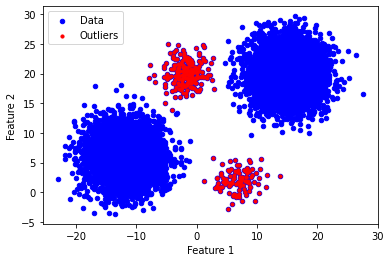

In [7]:
contamination = 0.03  # % (percentage) of outliers
n_train = 10000  # number of training points
n_test_size = 0.3  # %  (percentage)  of testing points
n_features = 2 # Number of features


n_out = int(n_train*contamination) # число выбросов
n_out_1 = int(n_out/3)
n_out_2 = n_out - (n_out_1)

np.random.RandomState(42)
np.random.seed(40)
from sklearn.datasets import make_blobs
#centers = [[-8, 8], [5, 15]] #anomal
centers = [[-12, 6], [15, 20]] #anomal
           
X = make_blobs(n_samples=n_train, n_features=n_features, centers=centers, random_state=1,
               cluster_std=3)[0] # center_box=(-10.0, 10.0)
#X[:n_out,:] = 10*np.random.rand(n_out, 2)-10

X[:n_out_1,:] = np.random.normal(7, 2, size=(n_out_1, 2))
X[:n_out_1,1]  = X[:n_out_1,1] - 5

X[n_out_1:n_out,:] = np.random.normal(10, 2, size=(n_out_2, 2))
X[n_out_1:n_out,1] = X[n_out_1:n_out,1] +10 
X[n_out_1:n_out,0] = X[n_out_1:n_out,0] -12

y = np.zeros(n_train)
y[:n_out] = 1
plt.scatter(X[:,0], X[:,1], c='#0000FF',s=20, label='Data')
plt.scatter(X[:n_out,0], X[:n_out,1], c='#FF0000', s=10, label='Outliers')
plt.xlabel(u'Feature 1')
plt.ylabel('Feature 2')
plt.legend()

#### Визуализация распределений признаков

Text(0.5, 1.0, 'Feature y')

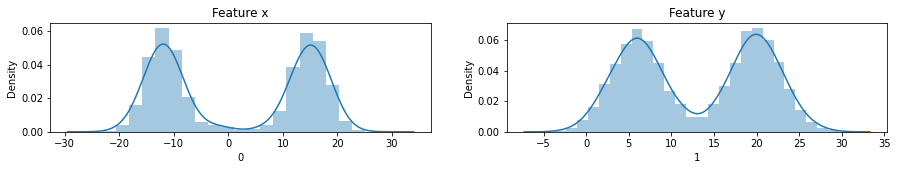

In [8]:
data = pd.DataFrame(X)
data.columns =['0', '1'] 
fig, ax = plt.subplots(figsize=(15,2), ncols=2, nrows=1)
sns.distplot(data['0'], ax=ax[0])
sns.distplot(data['1'], ax=ax[1])
ax[0].set_title("Feature x")
ax[1].set_title("Feature y")

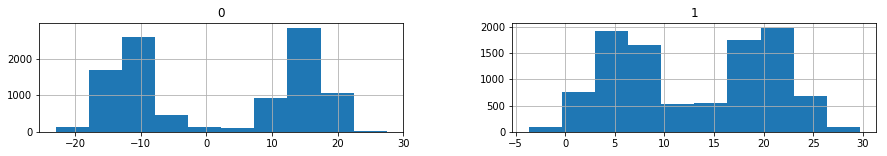

In [26]:
data.hist(figsize=(15, 2));

<AxesSubplot:xlabel='1'>

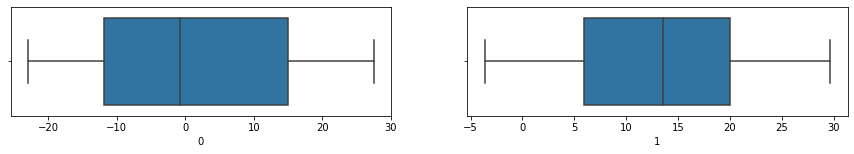

In [9]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 2))
sns.boxplot(x=data['0'],ax=axes[0])
sns.boxplot(x=data['1'],ax=axes[1])

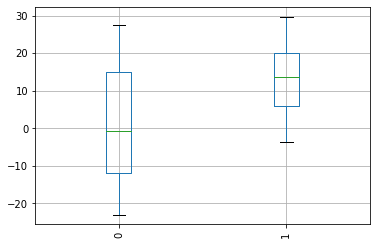

In [10]:
data.boxplot()
plt.xticks(rotation='vertical')
#plt.yscale('log')
plt.show()

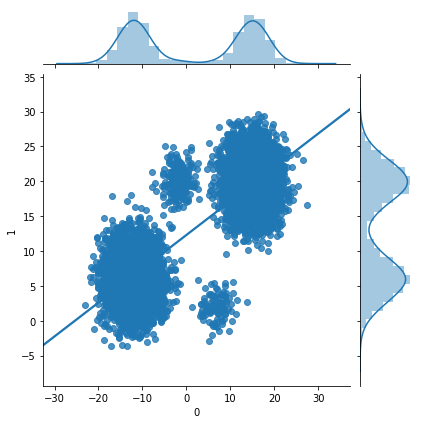

In [29]:
sns.jointplot(x='0', y='1', data=data, kind='reg');

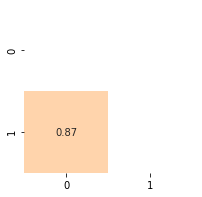

In [30]:
plt.figure(figsize=(3,3))
corr_matrix = data.corr()
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(np.bool))
sns.heatmap(lower, annot=True, fmt='.2f', cbar=False, center=0);

In [31]:
high_corr = [
    column for column in lower.columns if any((lower[column] > 0.3)|(lower[column] < -0.6))
]
high_corr

['0']

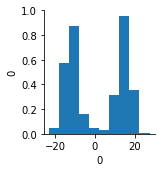

In [32]:
other_features = [col for col in data.columns if col not in high_corr and col!='quality']
sns.pairplot(data[high_corr]);

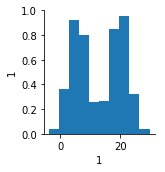

In [33]:
sns.pairplot(data[other_features]);

# Statistical Methods for Anomalous Detection

#### Determination of outliers using the 3 Sigma method

In [11]:
def outlier_std(data, col, threshold=3):
    mean = data[col].mean()
    std = data[col].std()
    up_bound = mean + threshold * std
    low_bound = mean - threshold * std
    anomalies = pd.concat([data[col]>up_bound, data[col]<low_bound], axis=1).any(1)
    
    return anomalies, up_bound, low_bound

def get_column_outliers(data, columns=None, function=outlier_std, threshold=3):
    if columns:
        columns_to_check = columns
    else:
        columns_to_check = data.columns
        
    outliers = pd.Series(data=[False]*len(data), index=data_features.index, name='is_outlier')
    comparison_table = {}
    for column in columns_to_check:
        anomalies, upper_bound, lower_bound = function(data, column, threshold=threshold)
        comparison_table[column] = [upper_bound, lower_bound, sum(anomalies), 100*sum(anomalies)/len(anomalies)]
        outliers[anomalies[anomalies].index] = True
    
    comparison_table = pd.DataFrame(comparison_table).T
    comparison_table.columns=['upper_bound', 'lower_bound', 'anomalies_count', 'anomalies_percentage']
    
    return comparison_table, outliers

def anomalies_report(outliers):
    print("Total number of outliers: {}\nPercentage of outliers:           {:.2f}%".format(
            sum(outliers), 100*sum(outliers)/len(outliers)))    

In [12]:
data_features = data.iloc[:, :]
comparison_table, std_outliers = get_column_outliers(data_features)
anomalies_report(std_outliers)

Total number of outliers: 0
Percentage of outliers:           0.00%


In [13]:
comparison_table

,upper_bound,lower_bound,anomalies_count,anomalies_percentage
0,42.483829,-39.431334,0.0,0.0
1,35.943485,-9.871658,0.0,0.0


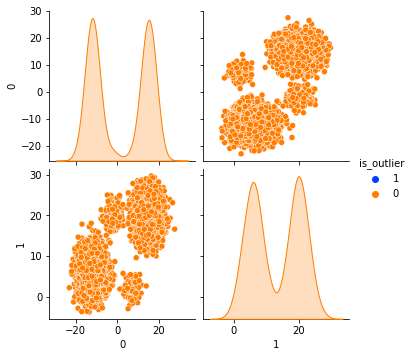

In [18]:
other_features = [col for col in data.columns]
labeled_data = data_features.copy()
labeled_data['is_outlier'] = std_outliers

sns.pairplot(data=labeled_data, vars = other_features,
             hue='is_outlier', hue_order=[1, 0],
             palette='bright');


In [19]:
data_features = data.iloc[:, :].copy()
scaler = RobustScaler()
scaled_data = pd.DataFrame(
    data=scaler.fit_transform(data_features), 
    columns=data_features.columns
)

#### Visualization of the original sample and the sample after applying the 3_Sigma method

In [22]:
def vizualisation_methods(labeled_data, name_method):
# выбросы - КРАСНЫЕ
    fig, ax = plt.subplots(figsize=(12,3), nrows=1, ncols=2)

#Original
    plt.subplot(121)
    ax = fig.add_subplot(121)
    plt.scatter(X[:,0], X[:,1], c='#0000FF',s=20, label='Normal Data')
    plt.scatter(X[:n_out,0], X[:n_out,1], c='#FF0000', s=10, label='Outliers')
    plt.xlabel('Feature x')
    plt.ylabel('Feature y')
    plt.title('ORIGINAL')
    plt.legend()

    plt.subplot(122)
    ax = fig.add_subplot(122)
    plt.scatter(labeled_data.iloc[:,0][labeled_data['is_outlier'] == False], 
            labeled_data.iloc[:,1][labeled_data['is_outlier'] == False], c='#0000FF',s=20, label='Normal Data')
    
    plt.scatter(labeled_data.iloc[:,0][labeled_data['is_outlier'] == True],
            labeled_data.iloc[:,1][labeled_data['is_outlier'] == True], c='#FF0000', s=10, label='Outliers')
    plt.xlabel('Feature x')
    plt.ylabel('Feature y')
    plt.title(name_method)
    plt.legend()
    print(f"Percentage of outliers: Original - {contamination*100} %;                           {name_method} - {100 - 100*len(labeled_data.iloc[:,0][labeled_data['is_outlier'] == False])/len(data):4.2f} %")

Percentage of outliers: Original - 3.0 %;                           3_Sigma - 0.00 %


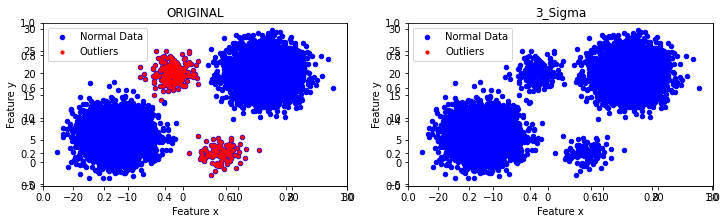

In [23]:
vizualisation_methods(labeled_data, name_method ='3_Sigma')

#### Determination of outliers using Quantile

In [24]:
def outlier_iqr(data, col, threshold=3):
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    up_bound = data[col].quantile(0.75) + (IQR * threshold)
    low_bound = data[col].quantile(0.25) - (IQR * threshold)
    anomalies = pd.concat([data[col]>up_bound, data[col]<low_bound], axis=1).any(1)
    return anomalies, up_bound, low_bound

In [25]:
comparison_table, iqr_outliers = get_column_outliers(data_features, function=outlier_iqr)
anomalies_report(iqr_outliers)

Total number of outliers: 0
Percentage of outliers:           0.00%


In [26]:
comparison_table

,upper_bound,lower_bound,anomalies_count,anomalies_percentage
0,95.500463,-92.320183,0.0,0.0
1,62.109932,-36.128736,0.0,0.0


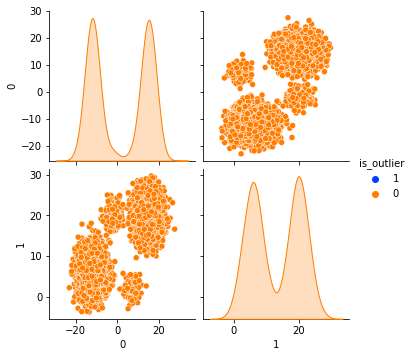

In [28]:
labeled_data = data_features.copy()
labeled_data['is_outlier'] = iqr_outliers

sns.pairplot(data=labeled_data, vars = other_features,
             hue='is_outlier', hue_order=[1, 0],
             palette='bright');


#### Visualization of the original sample and the sample after applying the Quantile

Percentage of outliers: Original - 3.0 %;                           Quantile (0,25 - 0,75) - 0.00 %


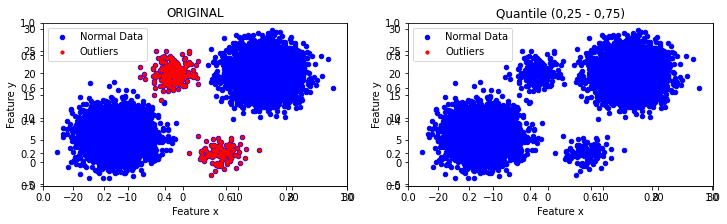

In [29]:
vizualisation_methods(labeled_data, name_method ='Quantile (0,25 - 0,75)')

### DBSCAN

In [30]:
#Set the estimated percentage of emissions
my_percentage = 0.03

# To begin with, we consider all observations to be anomalous.
outlier_percentage = 1.

num_clusters = []
anomaly_percentage = []

# We take a small epsilon and start increasing
eps = 0.01
eps_history = [eps]
while outlier_percentage>my_percentage:    
    model = DBSCAN(eps=eps).fit(scaled_data)
    labels = model.labels_
    num_clusters.append(len(np.unique(labels))-1)
    labels = np.array([1 if label == -1 else 0 for label in labels])
    # We consider the current percentage of "noise"
    outlier_percentage = sum(labels==1) / len(labels)    
    eps += 0.05
    eps_history.append(eps)
    anomaly_percentage.append(outlier_percentage)
    
model = DBSCAN(eps)
model.fit(scaled_data)
density_outlier = np.array([1 if label == -1 else 0 for label in model.labels_])
print('eps=', eps)

eps= 0.11000000000000001


In [31]:
anomalies_report(density_outlier)

Total number of outliers: 7
Percentage of outliers:           0.07%


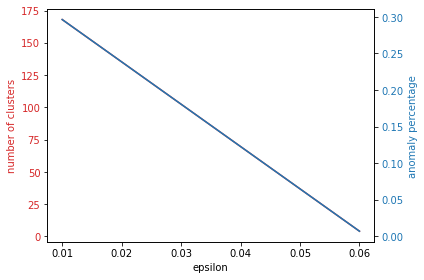

In [32]:
iterations = eps_history[:-1]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epsilon')
ax1.set_ylabel('number of clusters', color=color)
ax1.plot(iterations, num_clusters, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('anomaly percentage', color=color)  # we already handled the x-label with ax1
ax2.plot(iterations, anomaly_percentage, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

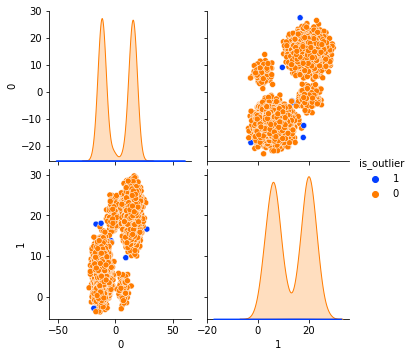

In [33]:
labeled_data = data_features.copy()
labeled_data['is_outlier'] = density_outlier

sns.pairplot(data=labeled_data, vars = other_features,
             hue='is_outlier', hue_order=[1, 0],
               palette='bright');

#### Visualization of the original sample and the sample after applying the DBSCAN

Percentage of outliers: Original - 3.0 %;                           DBSCAN - 0.07 %


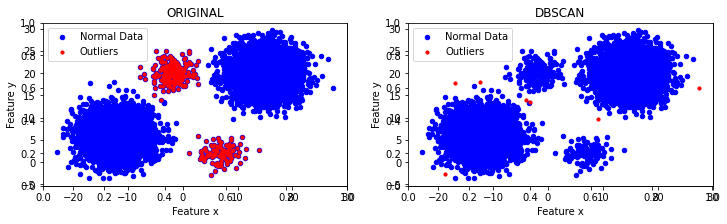

In [34]:
vizualisation_methods(labeled_data, name_method ='DBSCAN')

### OneClassSVM

In [35]:
one_class_svm = OneClassSVM(nu=contamination, gamma='auto')
one_class_svm.fit(scaled_data)
svm_outliers = one_class_svm.predict(scaled_data)
svm_outliers = np.array([1 if label == -1 else 0 for label in svm_outliers])

anomalies_report(svm_outliers)

Total number of outliers: 300
Percentage of outliers:           3.00%


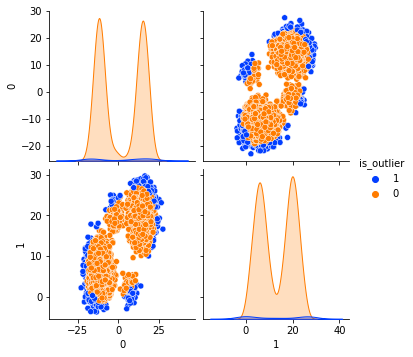

In [36]:
labeled_data = data_features.copy()
labeled_data['is_outlier'] = svm_outliers

sns.pairplot(data=labeled_data, vars = other_features,
             hue='is_outlier', hue_order=[1, 0],
             palette='bright');

#### Visualization of the original sample and the sample after applying the OneClassSVM

Percentage of outliers: Original - 3.0 %;                           OneClassSVM - 3.00 %


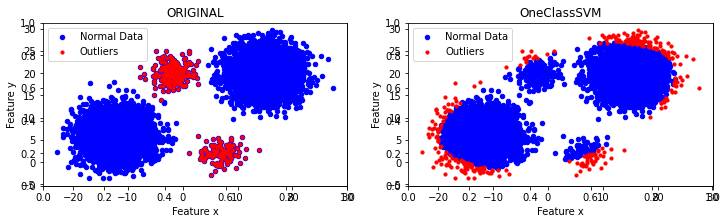

In [37]:
vizualisation_methods(labeled_data, name_method = 'OneClassSVM')

### IsolationForest

In [39]:
isolation_forest = IsolationForest(n_estimators=100, contamination=contamination, 
                                   max_features=1.0, bootstrap=True)
isolation_forest.fit(scaled_data)

isolation_outliers = isolation_forest.predict(scaled_data)
isolation_outliers = np.array([1 if label == -1 else 0 for label in isolation_outliers])

anomalies_report(isolation_outliers)

Total number of outliers: 300
Percentage of outliers:           3.00%


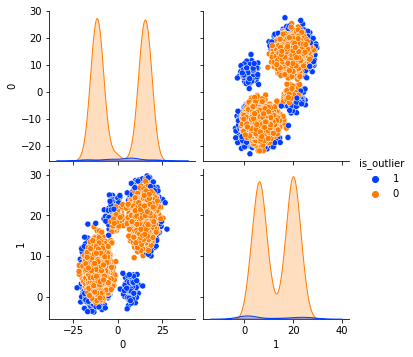

In [40]:
labeled_data = data_features.copy()
labeled_data['is_outlier'] = isolation_outliers

sns.pairplot(data=labeled_data, vars = other_features,
             hue='is_outlier', hue_order=[1, 0],
              palette='bright');

#### Visualization of the original sample and the sample after applying the IsolationForest

Percentage of outliers: Original - 3.0 %;                           IsolationForest - 3.00 %


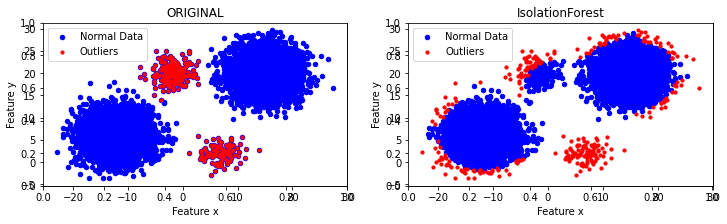

In [41]:
vizualisation_methods(labeled_data, name_method ='IsolationForest')

### LocalOutlierFactor

In [42]:
local_outlier_factor = LocalOutlierFactor(n_neighbors=300, contamination=contamination, novelty=False)
local_outlier_factor.fit(scaled_data)

local_factor_outliers = local_outlier_factor.fit_predict(scaled_data)
local_factor_outliers = np.array([1 if label == -1 else 0 for label in local_factor_outliers])

anomalies_report(local_factor_outliers)

Total number of outliers: 300
Percentage of outliers:           3.00%


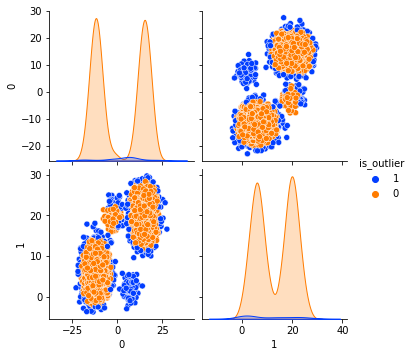

In [43]:
labeled_data = data_features.copy()
labeled_data['is_outlier'] = local_factor_outliers

sns.pairplot(data=labeled_data, vars = other_features,
             hue='is_outlier', hue_order=[1, 0],
             palette='bright');

#### Visualization of the original sample and the sample after applying the LocalOutlierFactor

Percentage of outliers: Original - 3.0 %;                           LocalOutlierFactor - 3.00 %


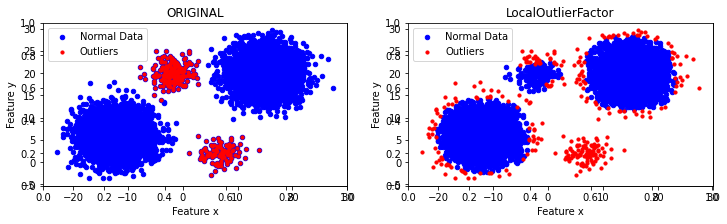

In [44]:
vizualisation_methods(labeled_data, name_method ='LocalOutlierFactor')

### EllipticEnvelope

In [45]:
elliptic_envelope = EllipticEnvelope(store_precision=True, assume_centered=False, support_fraction=None, contamination=contamination,
                       random_state=None)
elliptic_envelope.fit(scaled_data)
elliptic_envelope_outliers = elliptic_envelope.predict(scaled_data)
elliptic_envelope_outliers = np.array([1 if label == -1 else 0 for label in elliptic_envelope_outliers])
anomalies_report(elliptic_envelope_outliers)

Total number of outliers: 300
Percentage of outliers:           3.00%


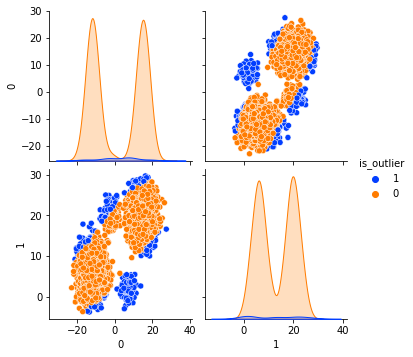

In [46]:
labeled_data = data_features.copy()
labeled_data['is_outlier'] = elliptic_envelope_outliers

sns.pairplot(data=labeled_data, vars = other_features,
             hue='is_outlier', hue_order=[1, 0],
             palette='bright');

#### Visualization of the original sample and the sample after applying the EllipticEnvelope

Percentage of outliers: Original - 3.0 %;                           EllipticEnvelope - 3.00 %


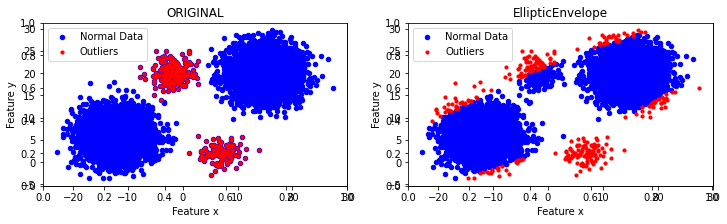

In [47]:
vizualisation_methods(labeled_data, name_method ='EllipticEnvelope')

# PyOD Methods

### KNN

In [48]:
n_neighbors = 10
knn = KNN(contamination = contamination, n_neighbors = n_neighbors)
knn.fit(scaled_data)
#knn_outliers = knn.labels_
knn_outliers = knn.predict(scaled_data)
knn_outliers = np.array([1 if label == 1 else 0 for label in knn_outliers])
anomalies_report(knn_outliers)

Total number of outliers: 273
Percentage of outliers:           2.73%


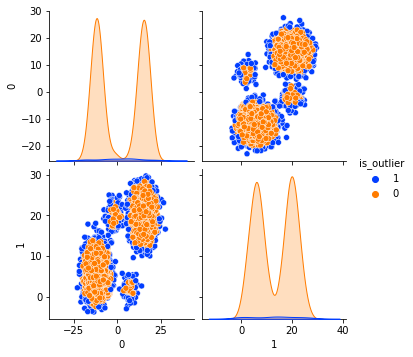

In [49]:
labeled_data = data_features.copy()
labeled_data['is_outlier'] = knn_outliers

sns.pairplot(data=labeled_data, vars = other_features,
             hue='is_outlier', hue_order=[1, 0],
             palette='bright');

Percentage of outliers: Original - 3.0 %;                           KNN - 2.73 %


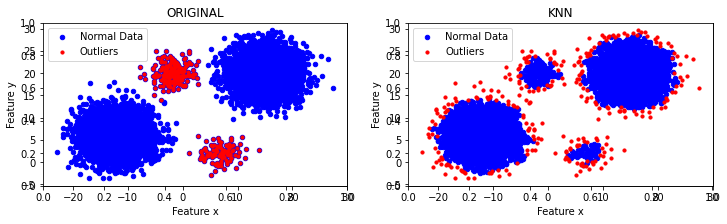

In [50]:
vizualisation_methods(labeled_data, name_method ='KNN')

### Cluster-based Local Outlier Factor (CBLOF)

In [51]:
cluster_based_lof = CBLOF(contamination=contamination, check_estimator=False, random_state=42)
cluster_based_lof.fit(scaled_data)
cluster_based_lof_outliers = cluster_based_lof.predict(scaled_data)
cluster_based_lof_outliers = np.array([1 if label == 1 else 0 for label in cluster_based_lof_outliers])
anomalies_report(cluster_based_lof_outliers)

Total number of outliers: 300
Percentage of outliers:           3.00%


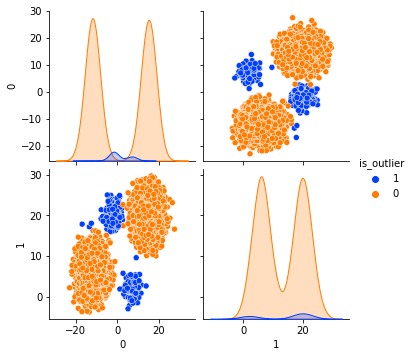

In [52]:
labeled_data = data_features.copy()
labeled_data['is_outlier'] = cluster_based_lof_outliers

sns.pairplot(data=labeled_data, vars = other_features,
             hue='is_outlier', hue_order=[1, 0],
             palette='bright');

Percentage of outliers: Original - 3.0 %;                           Cluster-based Local Outlier Factor - 3.00 %


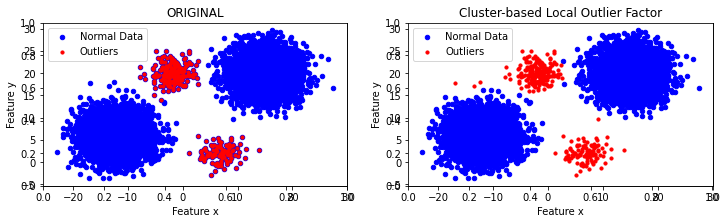

In [54]:
vizualisation_methods(labeled_data, name_method ='Cluster-based Local Outlier Factor')

### Histogram-base Outlier Detection (HBOS)

In [55]:
histogram_base = HBOS(contamination=contamination)
histogram_base.fit(scaled_data)
histogram_base_outliers = histogram_base.predict(scaled_data)
histogram_base_outliers = np.array([1 if label == 1 else 0 for label in histogram_base_outliers])
anomalies_report(histogram_base_outliers)

Total number of outliers: 250
Percentage of outliers:           2.50%


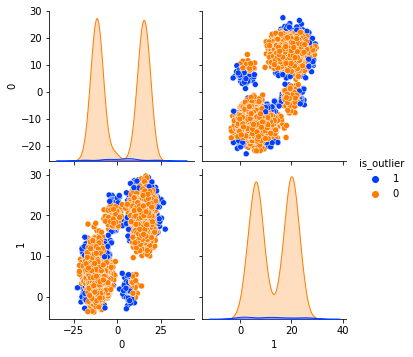

In [56]:
labeled_data = data_features.copy()
labeled_data['is_outlier'] = histogram_base_outliers

sns.pairplot(data=labeled_data, vars = other_features,
             hue='is_outlier', hue_order=[1, 0],
             palette='bright');

Percentage of outliers: Original - 3.0 %;                           Histogram-base Outlier Detection (HBOS) - 2.50 %


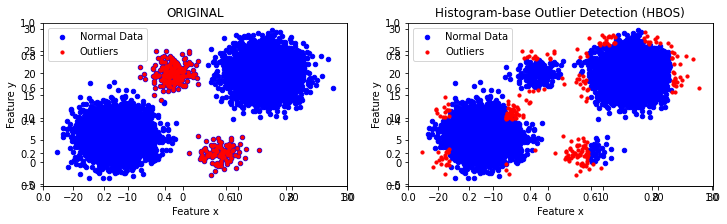

In [57]:
vizualisation_methods(labeled_data, name_method ='Histogram-base Outlier Detection (HBOS)')

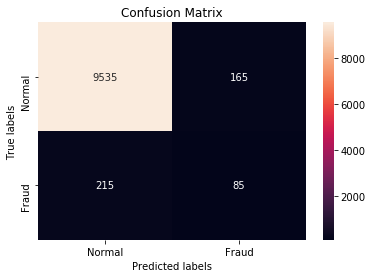

In [69]:
y_pred = histogram_base_outliers
conf_matrix = metrics.confusion_matrix(y,y_pred)

ax=plt.subplot()
sns.heatmap(conf_matrix,annot=True,ax=ax,fmt='g')#annot=True to annotate cells, fmt='g' numbers not scientific form
ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Normal', 'Fraud']); ax.yaxis.set_ticklabels(['Normal', 'Fraud']);
ax.set(yticks=[0, 2], 
       xticks=[0.5, 1.5])
ax.yaxis.set_major_locator(ticker.IndexLocator(base=1, offset=0.5))

### AutoEncoder

In [58]:
epochs = 25
autoencoder = AutoEncoder(epochs=epochs, contamination=contamination, hidden_neurons=[2,1,2] )
autoencoder.fit(scaled_data)

autoencoder_outliers = autoencoder.labels_
autoencoder_outliers = np.array([1 if label == 1 else 0 for label in autoencoder_outliers])
anomalies_report(autoencoder_outliers)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 6         
                                                                 
 dropout (Dropout)           (None, 2)                 0         
                                                                 
 dense_1 (Dense)             (None, 2)                 6         
                                                                 
 dropout_1 (Dropout)         (None, 2)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 6         
                                                                 
 dropout_2 (Dropout)         (None, 2)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3

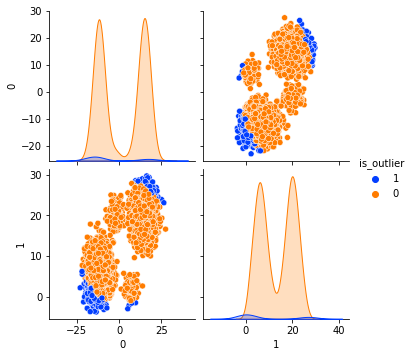

In [59]:
labeled_data = data_features.copy()
labeled_data['is_outlier'] = autoencoder_outliers

sns.pairplot(data=labeled_data, vars = other_features,
             hue='is_outlier', hue_order=[1, 0],
             palette='bright');

Percentage of outliers: Original - 3.0 %;                           Autoencoder - 3.00 %


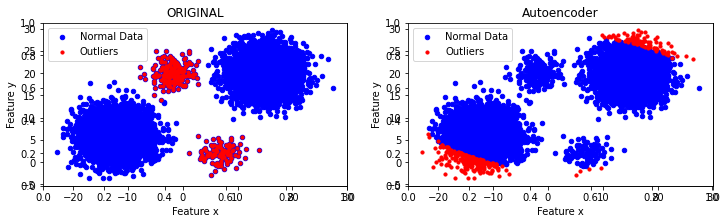

In [60]:
vizualisation_methods(labeled_data, name_method ='Autoencoder')

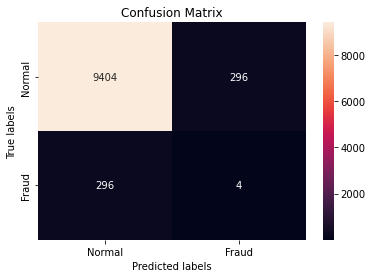

In [61]:
y_pred = autoencoder_outliers
conf_matrix = metrics.confusion_matrix(y,y_pred)

ax=plt.subplot()
sns.heatmap(conf_matrix,annot=True,ax=ax,fmt='g')#annot=True to annotate cells, fmt='g' numbers not scientific form
ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Normal', 'Fraud']); ax.yaxis.set_ticklabels(['Normal', 'Fraud']);
ax.set(yticks=[0, 2], 
       xticks=[0.5, 1.5])
ax.yaxis.set_major_locator(ticker.IndexLocator(base=1, offset=0.5))

In [74]:
y = y.reshape(-1, 1)
y_pred = y_pred.reshape(-1, 1)

In [76]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=1)

# Train the model using the training sets
knn_model.fit(y_pred, y)

KNeighborsClassifier(n_neighbors=1)

In [77]:
%%time
knn_predicted= knn_model.predict(autoencoder.labels_.reshape(-1, 1))

Wall time: 2.42 s


In [ ]:
# conf_matrix = metrics.confusion_matrix(y,knn_predicted)

ax=plt.subplot()
sns.heatmap(conf_matrix,annot=True,ax=ax,fmt='g')#annot=True to annotate cells, fmt='g' numbers not scientific form
ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Normal', 'Fraud']); ax.yaxis.set_ticklabels(['Normal', 'Fraud']);
ax.set(yticks=[0, 2], 
       xticks=[0.5, 1.5])
ax.yaxis.set_major_locator(ticker.IndexLocator(base=1, offset=0.5))

### Variational Auto Encoder (VAE) 

In [62]:
epochs = 5
autoencoder_vae = VAE(epochs=epochs, contamination=contamination, encoder_neurons=[2, 1, 2],
                      decoder_neurons=[2, 1, 2] )
autoencoder_vae.fit(scaled_data)

autoencoder_vae_outliers = autoencoder_vae.labels_
autoencoder_vae_outliers = np.array([1 if label == 1 else 0 for label in autoencoder_vae_outliers])
anomalies_report(autoencoder_vae_outliers)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 dense_6 (Dense)                (None, 2)            6           ['input_1[0][0]']                
                                                                                                  
 dense_7 (Dense)                (None, 2)            6           ['dense_6[0][0]']                
                                                                                                  
 dropout_5 (Dropout)            (None, 2)            0           ['dense_7[0][0]']                
                                                                                              

282/282 [==============================] - 6s 7ms/step - loss: 2.5049 - val_loss: 2.2121
Epoch 2/5
282/282 [==============================] - 2s 5ms/step - loss: 2.1179 - val_loss: 2.0290
Epoch 3/5
282/282 [==============================] - 1s 5ms/step - loss: 2.0521 - val_loss: 2.0130
Epoch 4/5
282/282 [==============================] - 1s 5ms/step - loss: 2.0318 - val_loss: 2.0013
Epoch 5/5
282/282 [==============================] - 1s 5ms/step - loss: 2.0289 - val_loss: 2.0000
Total number of outliers: 300
Percentage of outliers:           3.00%


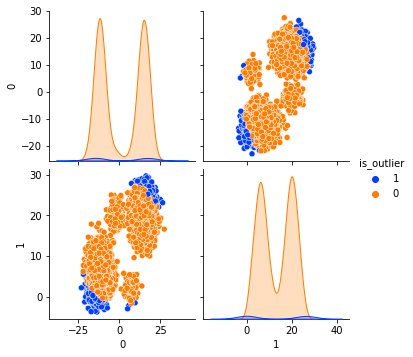

In [63]:
labeled_data = data_features.copy()
labeled_data['is_outlier'] = autoencoder_vae_outliers

sns.pairplot(data=labeled_data, vars = other_features,
             hue='is_outlier', hue_order=[1, 0],
             palette='bright');

Percentage of outliers: Original - 3.0 %;                           Autoencoder_vae - 3.00 %


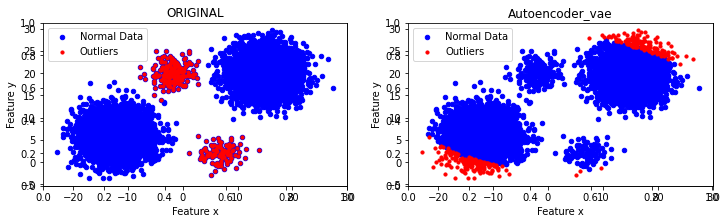

In [64]:
vizualisation_methods(labeled_data, name_method ='Autoencoder_vae')

### XGBOD

In [65]:
xgbod = XGBOD(contamination=contamination)
xgbod.fit(scaled_data, y)
xgbod_outliers = xgbod.predict(scaled_data)
xgbod_outliers = np.array([1 if label == 1 else 0 for label in xgbod_outliers])
anomalies_report(xgbod_outliers)

[15:13:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "contamination", "silent" } are not used.

Total number of outliers: 300
Percentage of outliers:           3.00%


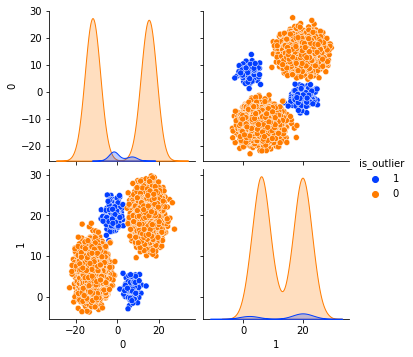

In [67]:
labeled_data = data_features.copy()
labeled_data['is_outlier'] = xgbod_outliers

sns.pairplot(data=labeled_data, vars = other_features,
             hue='is_outlier', hue_order=[1, 0],
             palette='bright');

Percentage of outliers: Original - 3.0 %;                           XGBOD - 3.00 %


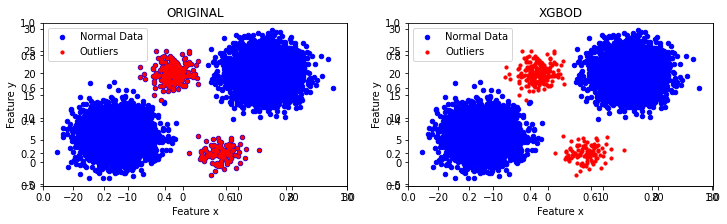

In [68]:
vizualisation_methods(labeled_data, name_method ='XGBOD')

# Comparison of Anomaly Detection Data Algorithms

In [71]:
summary = np.concatenate((
#Statistical
    [std_outliers], 
    [iqr_outliers], 
#    [euclidian_outliers], 
#    [cityblock_outliers],

#Scikit_learn    
    [density_outlier],
    [svm_outliers],
    [isolation_outliers],
    [local_factor_outliers],
    [elliptic_envelope_outliers],
    [knn_outliers],

    #PyOD    
    [cluster_based_lof_outliers],
    [histogram_base_outliers],
    [autoencoder_outliers]
    
))

summary = pd.DataFrame(
    summary.T, 
#    columns=['std', 'iqr', 'euclid', 'cityblock', 'dbscan', 'svm', 'isolation']
    columns=['std', 'iqr',  'dbscan', 'svm', 'isolation', 'lof', 'elliptic', 'knn', 'cblo', 'histogram', 'autoencoder']
)
print('The result of determining outliers by sample number for each model')
summary.head()

The result of determining outliers by sample number for each model


,std,iqr,dbscan,svm,isolation,lof,elliptic,knn,cblo,histogram,autoencoder
0,0,0,0,0,1,1,1,0,1,1,0
1,0,0,0,0,1,1,1,1,1,1,0
2,0,0,0,0,1,1,1,1,1,1,0
3,0,0,0,1,1,1,1,1,1,0,0
4,0,0,0,0,1,1,1,0,1,0,0


In [72]:
#The number of calculated outliers: "0" - no outliers for 900 cases for all models, "1" outlier - for 51 cases, ....
summary.sum(axis=1).value_counts()

0    9146
1     332
2     176
3      84
6      82
5      79
4      68
7      29
8       4
dtype: int64

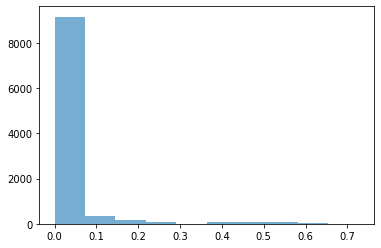

In [73]:
outlier_score = summary.mean(axis=1)
plt.hist(outlier_score, alpha=0.6);

# Combination of Anomaly Detection Data Algorithms

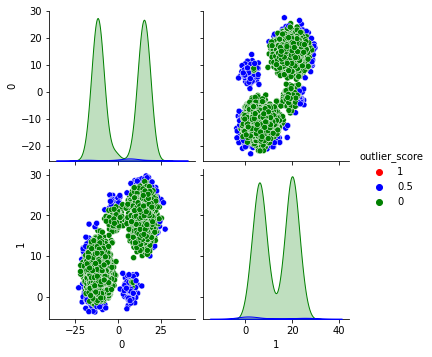

In [74]:
simple_score = outlier_score.apply(lambda x: 0 if x < 0.4 else 0.5 if x < 0.8 else 1)

labeled_data = data_features.copy()
labeled_data['outlier_score'] = simple_score

custom_palette = {0:'g', 0.5:'b', 1.0:'r'}

sns.pairplot(data=labeled_data, vars=other_features, 
             hue='outlier_score',
             hue_order=[1, 0.5, 0],
             palette=custom_palette
)

In [75]:
def vizualisation_methods_2(labeled_data, name_method):
    fig, ax = plt.subplots(figsize=(12,3), nrows=1, ncols=2)

#Original
    plt.subplot(121)
    ax = fig.add_subplot(121)
    plt.scatter(X[:,0], X[:,1], c='#0000FF',s=20, label='выборка')
    plt.scatter(X[:n_out,0], X[:n_out,1], c='#FF0000', s=10, label='выбросы')
    plt.xlabel('Feature x')
    plt.ylabel('Feature y')
    plt.title('ORIGINAL')
    plt.legend()

    plt.subplot(122)
    ax = fig.add_subplot(122)
    plt.scatter(labeled_data.iloc[:,0][labeled_data['outlier_score'] == False], 
            labeled_data.iloc[:,1][labeled_data['outlier_score'] == False], c='#0000FF',s=20, label='Normal Data')
    plt.scatter(labeled_data.iloc[:,0][labeled_data['outlier_score'] == 0.5], 
            labeled_data.iloc[:,1][labeled_data['outlier_score'] == 0.5], c='#00FF00',s=10, label='???')
    plt.scatter(labeled_data.iloc[:,0][labeled_data['outlier_score'] == True],
            labeled_data.iloc[:,1][labeled_data['outlier_score'] == True], c='#FF0000', s=10, label='Outliers')
    plt.xlabel('Feature x')
    plt.ylabel('Feature y')
    plt.title(name_method)
    plt.legend()
    print(f"Data outlier percentage: Original - {contamination*100} %;                   {name_method}  {100*len(labeled_data.iloc[:,0][labeled_data['outlier_score'] == 1])/len(data):4.2f} %")

Data outlier percentage: Original - 3.0 %;                   Combination of models (only red):  0.00 %


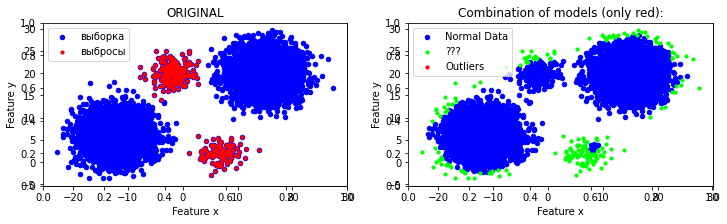

In [76]:
vizualisation_methods_2(labeled_data, 'Combination of models (only red):')

# Just model based

0    9353
1     342
3     135
2     135
4      35
dtype: int64

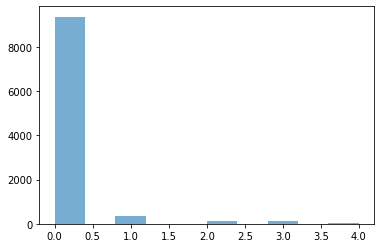

In [78]:
outliers_score_model_based = summary[['dbscan', 'svm', 'isolation', 'cblo', 'histogram']].sum(axis=1)
plt.hist(outliers_score_model_based, alpha=0.6);
outliers_score_model_based.value_counts()

Data outlier percentage - without'green': 6.47 %


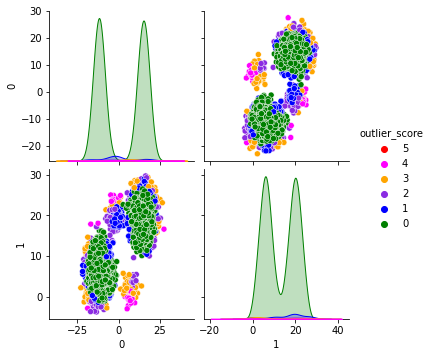

In [79]:
labeled_data = data_features.copy()
labeled_data['outlier_score'] = outliers_score_model_based

custom_palette = {0:'g', 1:'b', 2:'BlueViolet', 3:'orange', 4:'magenta', 5:'red'}

sns.pairplot(data=labeled_data, vars=other_features, 
             hue='outlier_score',
             hue_order=[5, 4, 3, 2, 1, 0],
             palette=custom_palette
)
print(f"Data outlier percentage - without'green': {len(labeled_data[labeled_data.outlier_score.isin([1,2,3,4,5])])*100/len(data):4.2f} %" )

In [82]:
def vizualisation_methods_3(labeled_data, name_method):
# выбросы - КРАСНЫЕ
    fig, ax = plt.subplots(figsize=(12,3), nrows=1, ncols=2)

#Original
    plt.subplot(121)
    ax = fig.add_subplot(121)
    plt.scatter(X[:,0], X[:,1], c='#0000FF',s=20, label='Normal Data')
    plt.scatter(X[:n_out,0], X[:n_out,1], c='#FF0000', s=10, label='Outliers')
    plt.xlabel('Feature x')
    plt.ylabel('Feature y')
    plt.title('ORIGINAL')
    plt.legend()

    plt.subplot(122)
    ax = fig.add_subplot(122)
    
    plt.scatter(labeled_data.iloc[:,0][labeled_data['outlier_score'] == 0], 
            labeled_data.iloc[:,1][labeled_data['outlier_score'] == 0], c='g',s=20, label='Data')
    
    plt.scatter(labeled_data.iloc[:,0][labeled_data['outlier_score'] == 1], 
            labeled_data.iloc[:,1][labeled_data['outlier_score'] == 1], c='b',s=10, label='q_0.2')
    
    plt.scatter(labeled_data.iloc[:,0][labeled_data['outlier_score'] == 2],
            labeled_data.iloc[:,1][labeled_data['outlier_score'] == 2], c='BlueViolet', s=10, label='q_0.4')
   
    plt.scatter(labeled_data.iloc[:,0][labeled_data['outlier_score'] == 3], 
            labeled_data.iloc[:,1][labeled_data['outlier_score'] == 3], c='orange',s=10, label='q_0.6')
    
    plt.scatter(labeled_data.iloc[:,0][labeled_data['outlier_score'] == 4],
            labeled_data.iloc[:,1][labeled_data['outlier_score'] == 4], c='magenta', s=10, label='q_0.8')
    
    plt.scatter(labeled_data.iloc[:,0][labeled_data['outlier_score'] == 5],
            labeled_data.iloc[:,1][labeled_data['outlier_score'] == 5], c='r', s=10, label='q_1.0')

    plt.xlabel('Feature x')
    plt.ylabel('Feature y')
    plt.title(name_method)
    plt.legend()
    print(f"Data outlier percentage: Original - {contamination*100} %;                   {name_method}  {100*len(labeled_data.iloc[:,0][labeled_data['outlier_score'] !=0])/len(data):4.2f} %")

Data outlier percentage: Original - 3.0 %;                   Combination of models (without green)  6.47 %


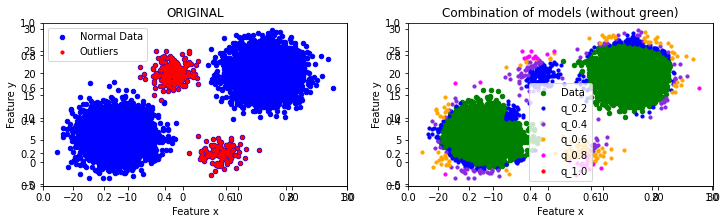

In [83]:
vizualisation_methods_3(labeled_data, 'Combination of models (without green)')

#### Data without explicit outliers

Data outlier percentage: 0.35 %


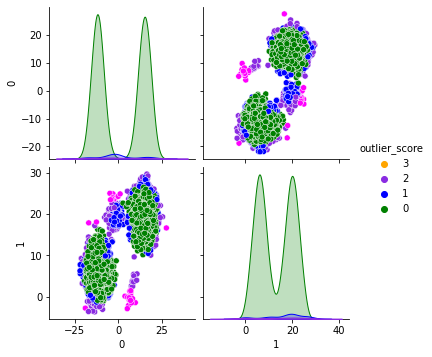

In [84]:
sns.pairplot(data=labeled_data[labeled_data.outlier_score!=3],
             vars=other_features, 
             hue='outlier_score',
             hue_order=[3, 2, 1, 0],
             palette=custom_palette
)
print(f"Data outlier percentage: {100 - len(labeled_data[labeled_data.outlier_score.isin([0,1,2,3])])*100/len(data):4.2f} %" )

In [85]:
def vizualisation_methods_4(labeled_data, name_method):
    fig, ax = plt.subplots(figsize=(12,3), nrows=1, ncols=2)

#Original
    plt.subplot(121)
    ax = fig.add_subplot(121)
    plt.scatter(X[:,0], X[:,1], c='#0000FF',s=20, label='выборка')
    plt.scatter(X[:n_out,0], X[:n_out,1], c='#FF0000', s=10, label='выбросы')
    plt.xlabel('Feature x')
    plt.ylabel('Feature y')
    plt.title('ORIGINAL')
    plt.legend()

    plt.subplot(122)
    ax = fig.add_subplot(122)
    
    plt.scatter(labeled_data.iloc[:,0][labeled_data['outlier_score'] == 0], 
            labeled_data.iloc[:,1][labeled_data['outlier_score'] == 0], c='g',s=20, label='Normal Data')
    
    plt.scatter(labeled_data.iloc[:,0][labeled_data['outlier_score'] == 1], 
            labeled_data.iloc[:,1][labeled_data['outlier_score'] == 1], c='b',s=10, label='q_0.2')
    
    plt.scatter(labeled_data.iloc[:,0][labeled_data['outlier_score'] == 2],
            labeled_data.iloc[:,1][labeled_data['outlier_score'] == 2], c='BlueViolet', s=10, label='q_0.4')
   
    plt.scatter(labeled_data.iloc[:,0][labeled_data['outlier_score'] == 3], 
            labeled_data.iloc[:,1][labeled_data['outlier_score'] == 3], c='orange',s=10, label='q_0.6')
    

    plt.xlabel('Feature x')
    plt.ylabel('Feature y')
    plt.title(name_method)
    plt.legend()
    print(f"Data outlier percentage: Original - {contamination*100} %;                   {name_method}  {100 - len(labeled_data[labeled_data.outlier_score.isin([0,1,2,3])])*100/len(data):4.2f} %")

Data outlier percentage: Original - 3.0 %;                   Combination of models (without red_5+magenta_4)  0.35 %


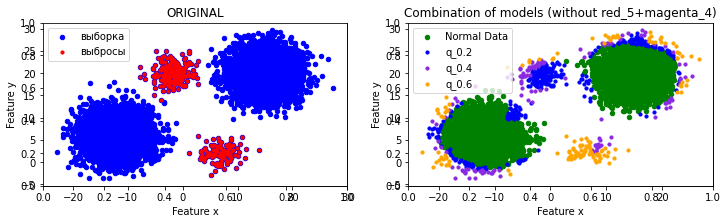

In [86]:
vizualisation_methods_4(labeled_data, 'Combination of models (without red_5+magenta_4)')

#### Sample with high probability of normal data

Data outlier percentage: 3.05 %


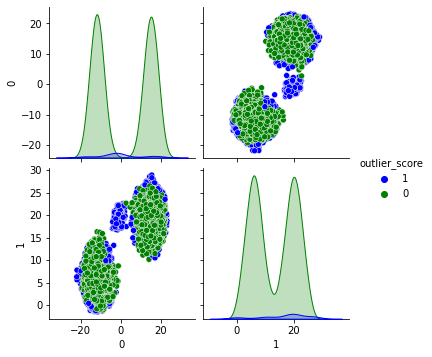

In [87]:
sns.pairplot(data=labeled_data[labeled_data.outlier_score.isin([0, 1])],
             vars=other_features, 
             hue='outlier_score',
             hue_order=[1, 0],
             palette=custom_palette
)
print(f"Data outlier percentage: {100 - len(labeled_data[labeled_data.outlier_score.isin([0,1])])*100/len(data):4.2f} %" )

In [90]:
def vizualisation_methods_5(labeled_data, name_method):
    fig, ax = plt.subplots(figsize=(12,3), nrows=1, ncols=2)

#Original
    plt.subplot(121)
    ax = fig.add_subplot(121)
    plt.scatter(X[:,0], X[:,1], c='#0000FF',s=20, label='Normal Data')
    plt.scatter(X[:n_out,0], X[:n_out,1], c='#FF0000', s=10, label='Outliers')
    plt.xlabel('Feature x')
    plt.ylabel('Feature y')
    plt.title('ORIGINAL')
    plt.legend()

    plt.subplot(122)
    ax = fig.add_subplot(122)
    
    plt.scatter(labeled_data.iloc[:,0][labeled_data['outlier_score'] == 0], 
            labeled_data.iloc[:,1][labeled_data['outlier_score'] == 0], c='g',s=20, label='Normal Data')
    
    plt.scatter(labeled_data.iloc[:,0][labeled_data['outlier_score'] == 1], 
            labeled_data.iloc[:,1][labeled_data['outlier_score'] == 1], c='b',s=10, label='q_0.2')
    
    plt.xlabel('Feature x')
    plt.ylabel('Feature y')
    plt.title(name_method)
    plt.legend()
    print(f"Data outlier percentage: Original - {contamination*100} %;         {name_method}  {100 - len(labeled_data[labeled_data.outlier_score.isin([0,1])])*100/len(data):4.2f} %")

Data outlier percentage: Original - 3.0 %;         Combination of models (without: red_5+magenta_4+orange_3+BlueViolet_2)  3.05 %


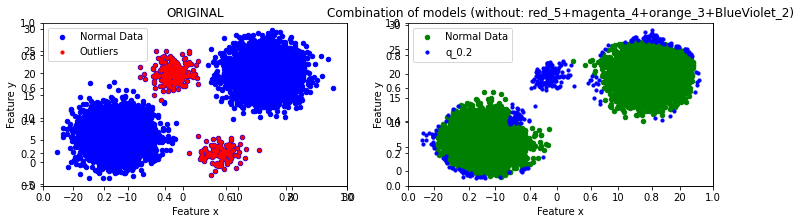

In [91]:
vizualisation_methods_5(labeled_data, 'Combination of models (without: red_5+magenta_4+orange_3+BlueViolet_2)')

#### Data WITHOUT Outliers

Data outlier percentage: 6.47 %


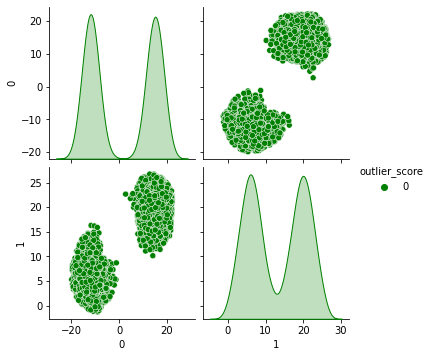

In [92]:
sns.pairplot(data=labeled_data[labeled_data.outlier_score.isin([0])],
             vars=other_features, 
             hue='outlier_score',
             hue_order=[0],
             palette=custom_palette
)
print(f"Data outlier percentage: {100 - len(labeled_data[labeled_data.outlier_score.isin([0])])*100/len(data):4.2f} %" )

In [95]:
def vizualisation_methods_6(labeled_data, name_method):
# выбросы - КРАСНЫЕ
    fig, ax = plt.subplots(figsize=(12,3), nrows=1, ncols=2)

#Original
    plt.subplot(121)
    ax = fig.add_subplot(121)
    plt.scatter(X[:,0], X[:,1], c='#0000FF',s=20, label='Normal Data')
    plt.scatter(X[:n_out,0], X[:n_out,1], c='#FF0000', s=10, label='Outliers')
    plt.xlabel('Feature x')
    plt.ylabel('Feature y')
    plt.title('ORIGINAL')
    plt.legend()

    plt.subplot(122)
    ax = fig.add_subplot(122)
    
    plt.scatter(labeled_data.iloc[:,0][labeled_data['outlier_score'] == 0], 
            labeled_data.iloc[:,1][labeled_data['outlier_score'] == 0], c='g',s=20, label='Normal Data')
    
   
    plt.xlabel('Feature x')
    plt.ylabel('Feature y')
    plt.title(name_method)
    plt.legend()
    print(f"Data outlier percentage: Original - {contamination*100} %;         {name_method}  {100 - len(labeled_data[labeled_data.outlier_score.isin([0])])*100/len(data):4.2f} %")

Data outlier percentage: Original - 3.0 %;         Combination of models (only green)  6.47 %


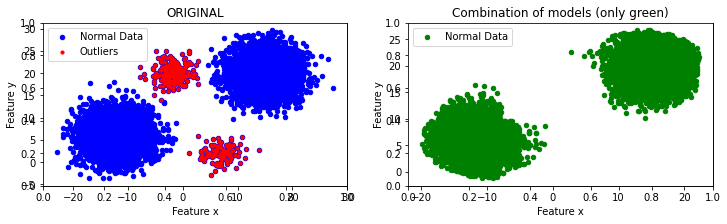

In [96]:
vizualisation_methods_6(labeled_data, 'Combination of models (only green)')

####  f1_score

In [129]:
#Определение f1_score по всей выборке
std_outliers_ = np.array(std_outliers.apply(lambda x: 0 if x ==False else 1))
iqr_outliers_ = np.array(iqr_outliers.apply(lambda x: 0 if x ==False else 1))
summary_outlier_array = (std_outliers_, iqr_outliers_, density_outlier, svm_outliers, isolation_outliers, local_factor_outliers,
                        elliptic_envelope_outliers, knn_outliers, cluster_based_lof_outliers, histogram_base_outliers, autoencoder_outliers)
k=0
for i in summary_outlier_array:
    print(f" {k+1}) f1_score: {summary.columns[k]} = {f1_score(y, i, average='macro'):6.4f}")
    k+=1

 1) f1_score: std = 0.4924
 2) f1_score: iqr = 0.4924
 3) f1_score: dbscan = 0.4955
 4) f1_score: svm = 0.5808
 5) f1_score: isolation = 0.7526
 6) f1_score: lof = 0.7285
 7) f1_score: elliptic = 0.7852
 8) f1_score: knn = 0.6470
 9) f1_score: cblo = 0.9931
 10) f1_score: histogram = 0.6448
 11) f1_score: autoencoder = 0.4914


# Formation  TRAIN & TEST 

In [98]:
# Разбиение на TRAIN & TEST 
df = pd.DataFrame(X)
df['y'] =y 
df = shuffle(df, random_state=42)
train, test = train_test_split(df, test_size=n_test_size, random_state=1)

traine_outlier: 2.97 %
test_outlier:   3.07 % 


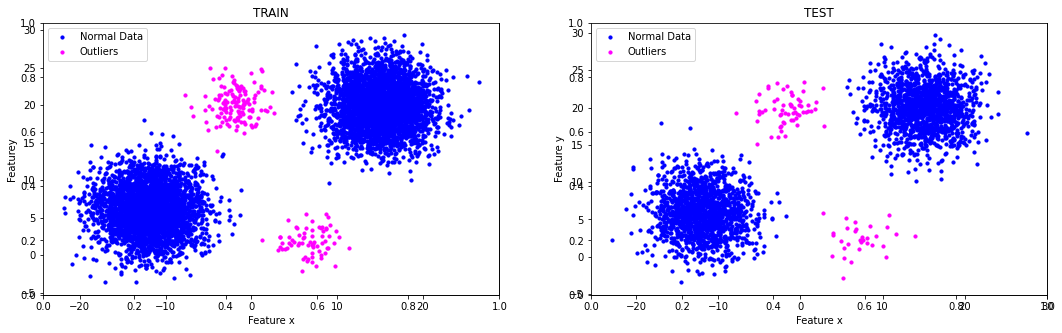

In [99]:
fig, ax = plt.subplots(figsize=(18,5), nrows=1, ncols=2)
# Посмoтрим выбросы - КРАСНЫЕ

#Трейновая выборка
train_in = train[train.y==0.0]
train_out = train[train.y==1.0]
plt.subplot(121)
ax = fig.add_subplot(121)
plt.scatter(train_in.iloc[:,0], train_in.iloc[:,1], c='#0000FF', s = 10, label='Normal Data')
plt.scatter(train_out.iloc[:,0], train_out.iloc[:,1], c='#FF00FF', s = 10, label='Outliers')
plt.xlabel('Feature x')
plt.ylabel('Featurey')
plt.title('TRAIN')
plt.legend()

#Тестовая выборка
test_in = test[test.y==0.0]
test_out = test[test.y==1.0]
plt.subplot(122)
ax = fig.add_subplot(122)
plt.scatter(test_in.iloc[:,0], test_in.iloc[:,1], c='#0000FF', s = 10, label='Normal Data')
plt.scatter(test_out.iloc[:,0], test_out.iloc[:,1], c='#FF00FF', s = 10, label='Outliers')
plt.xlabel('Feature x')
plt.ylabel('Feature y')
plt.title('TEST')
plt.legend()

print(f"traine_outlier: {len(train[train.y==1])*100/len(train):4.2f} %")
print(f"test_outlier:   {len(test[test.y==1])*100/len(test):4.2f} % ")

In [100]:
X_train = train.iloc[:,:-1].copy()
y_train = train.iloc[:,2].copy()

X_test = test.iloc[:,:-1].copy()
y_test= test.iloc[:,2].copy()
X_train.index = np.arange(len(X_train))
X_test.index = np.arange(len(X_test))

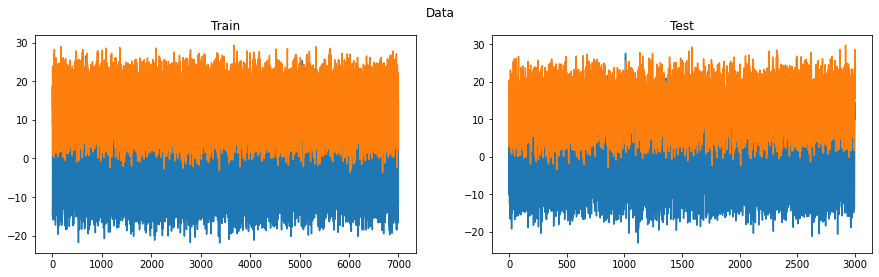

In [101]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
fig.suptitle('Data')
ax1.set_title('Train')
ax1.plot(X_train.iloc[:, :])
ax2.set_title('Test')
ax2.plot(X_test.iloc[:, :])

#X_test.iloc[:, :].plot(legend=None, title='X_test')

### TRAIN and TEST Data Preparation

In [104]:
# scaler
scaler = RobustScaler()

data_X_train = pd.DataFrame(X_train)
data_X_train.columns =['0', '1'] 

data_X_test = pd.DataFrame(X_test)
data_X_test.columns =['0', '1'] 

data_features_train = X_train.iloc[:, :]
data_features_test = X_test.iloc[:, :]

scaled_data_train = pd.DataFrame(
    data=scaler.fit_transform(data_features_train), 
    columns=data_features_train.columns
)
scaled_data_test = pd.DataFrame(
    data=scaler.fit_transform(data_features_test), 
    columns=data_features_test.columns
)

In [105]:
def vizualisation_methods_test(test, labeled_data_test, name_method):
    fig, ax = plt.subplots(figsize=(12,3), nrows=1, ncols=2)

#Тестовая выборка Original
    test_in = test[test.y==0.0]
    test_out = test[test.y==1.0]
    plt.subplot(121)
    ax = fig.add_subplot(121)
    plt.scatter(test_in.iloc[:,0], test_in.iloc[:,1], c='#0000FF', s = 10, label='Normal Data')
    plt.scatter(test_out.iloc[:,0], test_out.iloc[:,1], c='#FF00FF', s = 10, label='Outliers')
    plt.xlabel('Feature x')
    plt.ylabel('Feature y')
    plt.title('TEST Original')
    plt.legend()

    plt.subplot(122)
    ax = fig.add_subplot(122)
    plt.scatter(labeled_data_test.iloc[:,0][labeled_data_test['is_outlier'] == False], 
            labeled_data_test.iloc[:,1][labeled_data_test['is_outlier'] == False], c='#0000FF',s=10, label='Normal Data')
    
    plt.scatter(labeled_data_test.iloc[:,0][labeled_data_test['is_outlier'] == True],
            labeled_data_test.iloc[:,1][labeled_data_test['is_outlier'] == True], c='#FF0000', s=10, label='Outliers')
    plt.xlabel('Feature x')
    plt.ylabel('Feature y')
    plt.title(name_method)
    plt.legend()
    print(f"Data outlier percentage: Original TEST - {contamination*100} %;                           {name_method} - {100 - 100*len(labeled_data_test.iloc[:,0][labeled_data_test['is_outlier'] == False])/len(test):4.2f} %")

### KNN

In [106]:
#n_neighbors = 1
knn = KNN(contamination = contamination)
knn.fit(scaled_data_train)
#knn_outliers = knn.labels_
knn_outliers_train = knn.predict(scaled_data_train)
knn_outliers_train = np.array([1 if label == 1 else 0 for label in knn_outliers_train])
anomalies_report(knn_outliers_train)
print(f"f1_score_for_Train:  {f1_score(y_train, knn_outliers_train, average='macro'):6.4f}")

Total number of outliers: 160
Percentage of outliers:           2.29%
f1_score_for_Train:  0.6205


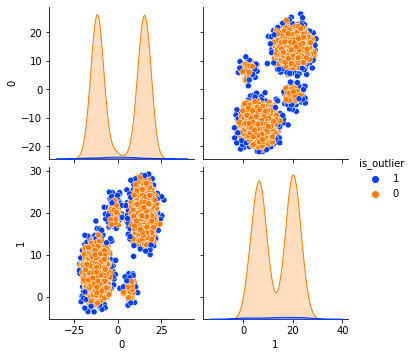

In [107]:
other_features_train = [col for col in data_X_train.columns]
labeled_data_train = data_features_train
labeled_data_train['is_outlier'] = knn_outliers_train

sns.pairplot(data=labeled_data_train, vars = other_features_train,
             hue='is_outlier', hue_order=[1, 0],
             palette='bright');


In [108]:
#knn.fit(scaled_data_test)
knn_outliers_test = knn.predict(scaled_data_test)
knn_outliers_test = np.array([1 if label == 1 else 0 for label in knn_outliers_test])
anomalies_report(knn_outliers_test)
print(f"f1_score_for_Test:  {f1_score(y_test, knn_outliers_test, average='macro'):6.4f}")

Total number of outliers: 175
Percentage of outliers:           5.83%
f1_score_for_Test:  0.6688


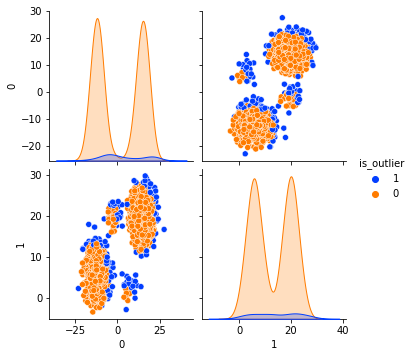

In [110]:
other_features_test = [col for col in data_X_test.columns]
labeled_data_test = data_features_test.copy()
labeled_data_test['is_outlier'] = knn_outliers_test

sns.pairplot(data=labeled_data_test, vars = other_features_test,
             hue='is_outlier', hue_order=[1, 0],
             palette='bright');

Data outlier percentage: Original TEST - 3.0 %;                           KNN - for Test - 5.83 %


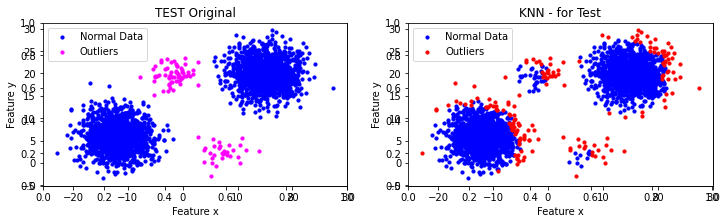

In [111]:
vizualisation_methods_test(test, labeled_data_test, 'KNN - for Test')

### IsolationForest

In [113]:
isolation_forest = IsolationForest(n_estimators=10, contamination=contamination, 
                                   max_features=1.0, bootstrap=True)
isolation_forest.fit(scaled_data_train)

isolation_outliers_train = isolation_forest.predict(scaled_data_train)
isolation_outliers_train = np.array([1 if label == -1 else 0 for label in isolation_outliers_train])

anomalies_report(isolation_outliers_train)
print(f"f1_score_for_Train:  {f1_score(y_train, isolation_outliers_train, average='macro'):6.4f}")

Total number of outliers: 205
Percentage of outliers:           2.93%
f1_score_for_Train:  0.8266


In [114]:
#isolation_forest.fit(scaled_data_test)
isolation_outliers_test = isolation_forest.predict(scaled_data_test)
isolation_outliers_test = np.array([1 if label == -1 else 0 for label in isolation_outliers_test])
anomalies_report(isolation_outliers_test)
print(f"f1_score_for_Test:  {f1_score(y_test, isolation_outliers_test, average='macro'):6.4f}")

Total number of outliers: 68
Percentage of outliers:           2.27%
f1_score_for_Test:  0.7881


Data outlier percentage: Original TEST - 3.0 %;                           IsolationForest - for Test - 2.27 %


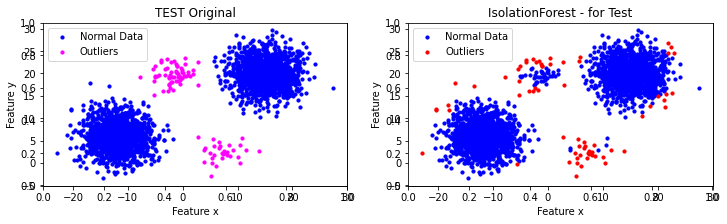

In [115]:
labeled_data_test['is_outlier'] = isolation_outliers_test
vizualisation_methods_test(test, labeled_data_test, 'IsolationForest - for Test')

In [116]:
from sklearn.manifold import TSNE
tsne = TSNE(verbose=1,n_iter=5000)
res = tsne.fit_transform(scaled_data_train)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7000 samples in 0.012s...
[t-SNE] Computed neighbors for 7000 samples in 0.259s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7000
[t-SNE] Computed conditional probabilities for sample 2000 / 7000
[t-SNE] Computed conditional probabilities for sample 3000 / 7000
[t-SNE] Computed conditional probabilities for sample 4000 / 7000
[t-SNE] Computed conditional probabilities for sample 5000 / 7000
[t-SNE] Computed conditional probabilities for sample 6000 / 7000
[t-SNE] Computed conditional probabilities for sample 7000 / 7000
[t-SNE] Mean sigma: 0.017809
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.698982
[t-SNE] KL divergence after 5000 iterations: 0.666010


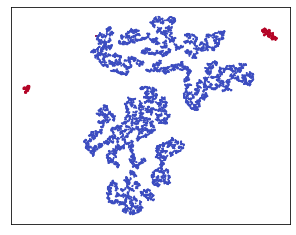

In [117]:
fig = plt.figure(figsize=(5,4))
scatter =plt.scatter(res[:,0],res[:,1],c=y_train, cmap='coolwarm', s=0.6)
scatter.axes.get_xaxis().set_visible(False)
scatter.axes.get_yaxis().set_visible(False)


### LocalOutlierFactor

In [118]:
local_outlier_factor = LocalOutlierFactor( n_neighbors=200, contamination=contamination, novelty=False)
local_outlier_factor.fit(scaled_data_train)

local_factor_outliers_train = local_outlier_factor.fit_predict(scaled_data_train)
local_factor_outliers_train = np.array([1 if label == -1 else 0 for label in local_factor_outliers_train])

anomalies_report(local_factor_outliers_train)
print(f"f1_score_for_Train:  {f1_score(y_train, local_factor_outliers_train, average='macro'):6.4f}")

Total number of outliers: 210
Percentage of outliers:           3.00%
f1_score_for_Train:  0.7115


In [119]:
#local_outlier_factor.fit(scaled_data_test)
local_factor_outliers_test = local_outlier_factor.fit_predict(scaled_data_test)
local_factor_outliers_test = np.array([1 if label == -1 else 0 for label in local_factor_outliers_test])
anomalies_report(local_factor_outliers_test)
print(f"f1_score_for_Test:  {f1_score(y_test, local_factor_outliers_test, average='macro'):6.4f}")

Total number of outliers: 90
Percentage of outliers:           3.00%
f1_score_for_Test:  0.9547


Data outlier percentage: Original TEST - 3.0 %;                           LocalOutlierFactor - for Test - 3.00 %


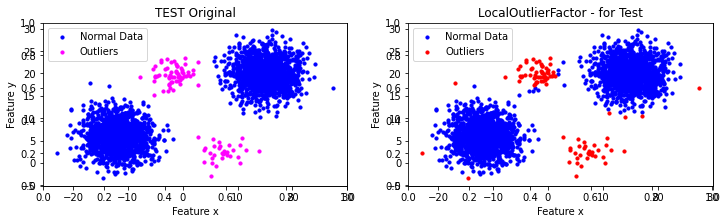

In [120]:
labeled_data_test['is_outlier'] = local_factor_outliers_test
vizualisation_methods_test(test, labeled_data_test, 'LocalOutlierFactor - for Test')

### OneClassSVM

In [121]:
one_class_svm = OneClassSVM(nu=contamination, gamma='auto')
one_class_svm.fit(scaled_data_train)
svm_outliers_train = one_class_svm.predict(scaled_data_train)
svm_outliers_train = np.array([1 if label == -1 else 0 for label in svm_outliers_train])
anomalies_report(svm_outliers_train)
print(f"f1_score_for_Train:  {f1_score(y_train, svm_outliers_train, average='macro'):6.4f}")

Total number of outliers: 209
Percentage of outliers:           2.99%
f1_score_for_Train:  0.5810


In [122]:
one_class_svm_outliers_test = one_class_svm.predict(scaled_data_test)
one_class_svm_outliers_test = np.array([1 if label == -1 else 0 for label in one_class_svm_outliers_test])
anomalies_report(one_class_svm_outliers_test)
print(f"f1_score_for_Test:  {f1_score(y_test, one_class_svm_outliers_test, average='macro'):6.4f}")

Total number of outliers: 128
Percentage of outliers:           4.27%
f1_score_for_Test:  0.5470


Data outlier percentage: Original TEST - 3.0 %;                           OneClassSVM - for Test - 4.27 %


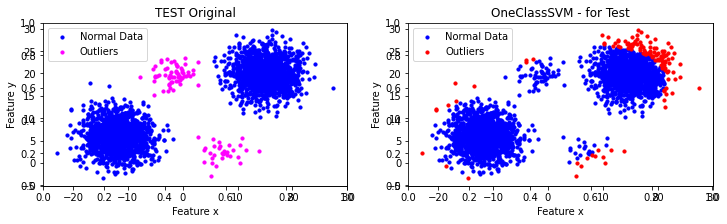

In [123]:
labeled_data_test['is_outlier'] = one_class_svm_outliers_test
vizualisation_methods_test(test, labeled_data_test, 'OneClassSVM - for Test')

### CBLOF

In [124]:
cluster_based_lof = CBLOF(contamination=contamination, check_estimator=False, random_state=42)
cluster_based_lof.fit(scaled_data_train)
cblof_outliers_train = cluster_based_lof.predict(scaled_data_train)
cblof_outliers_train = np.array([1 if label == 1 else 0 for label in cblof_outliers_train])
anomalies_report(cblof_outliers_train)
print(f"f1_score_for_Train:  {f1_score(y_train, cblof_outliers_train, average='macro'):6.4f}")

Total number of outliers: 210
Percentage of outliers:           3.00%
f1_score_for_Train:  0.9951


In [125]:
cblof_outliers_test = cluster_based_lof.predict(scaled_data_test)
cblof_outliers_test = np.array([1 if label == 1 else 0 for label in cblof_outliers_test])
anomalies_report(cblof_outliers_test)
print(f"f1_score_for_Test:  {f1_score(y_test, cblof_outliers_test, average='macro'):6.4f}")

Total number of outliers: 89
Percentage of outliers:           2.97%
f1_score_for_Test:  0.9630


Data outlier percentage: Original TEST - 3.0 %;                           cblof - for Test - 2.97 %


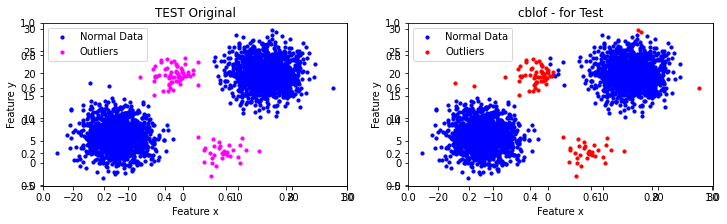

In [126]:
labeled_data_test['is_outlier'] = cblof_outliers_test
vizualisation_methods_test(test, labeled_data_test, 'cblof - for Test')

### XGBOD

In [127]:
xgbod = XGBOD(contamination=contamination)
xgbod.fit(scaled_data_train, y_train)

xgbod_outliers_train =xgbod.predict(scaled_data_train)
xgbod_outliers_train = np.array([1 if label == 1 else 0 for label in xgbod_outliers_train])
anomalies_report(xgbod_outliers_train)
print(f"f1_score_for_Train:  {f1_score(y_train, xgbod_outliers_train, average='macro'):6.4f}")

[15:47:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "contamination", "silent" } are not used.

Total number of outliers: 208
Percentage of outliers:           2.97%
f1_score_for_Train:  1.0000


In [128]:
xgbod_outliers_test = xgbod.predict(scaled_data_test)
xgbod_outliers_test = np.array([1 if label == 1 else 0 for label in xgbod_outliers_test])
anomalies_report(xgbod_outliers_test)
print(f"f1_score_for_Test:  {f1_score(y_test, xgbod_outliers_test, average='macro'):6.4f}")

Total number of outliers: 79
Percentage of outliers:           2.63%
f1_score_for_Test:  0.9609


Data outlier percentage: Original TEST - 3.0 %;                           cblof - for Test - 2.63 %


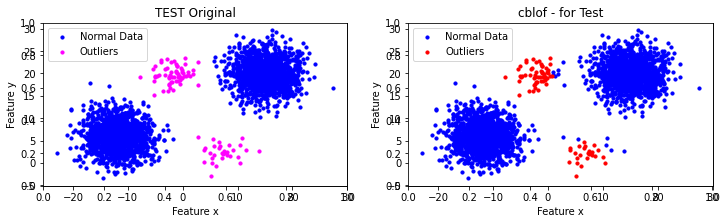

In [129]:
labeled_data_test['is_outlier'] = xgbod_outliers_test
vizualisation_methods_test(test, labeled_data_test, 'cblof - for Test')

# Classification methods Sklearn

### SGDClassifier

In [130]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
clf_sgd = SGDClassifier(max_iter=1000, loss='log', tol=1e-3, random_state=42,  alpha=0.001)
clf_sgd.fit(scaled_data_train, y_train)

sgd_outliers_train = clf_sgd.predict(scaled_data_train)
#print(sgd_outliers_train[:30])
csgd_outliers_train = np.array([1 if label == 1 else 0 for label in sgd_outliers_train])
anomalies_report(sgd_outliers_train)
print(f"f1_score_for_Train:  {f1_score(y_train, sgd_outliers_train, average='macro'):6.4f}")

scores = cross_val_score(clf_sgd, scaled_data_train, y_train, cv=5, scoring='roc_auc')
print('Cross_Val_Score:', scores, scores.mean()) 


Total number of outliers: 0.0
Percentage of outliers:           0.00%
f1_score_for_Train:  0.4925
Cross_Val_Score: [0.63052101 0.67644789 0.65344695 0.70581738 0.63186409] 0.6596194615260964


Total number of outliers: 0
Percentage of outliers:           0.00%
f1_score_for_Test:  0.4922
Data outlier percentage: Original TEST - 3.0 %;                           SGDClassifier - for Test - 0.00 %


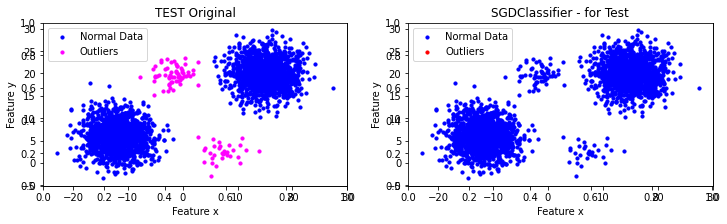

In [131]:
sgd_outliers_test = clf_sgd.predict(scaled_data_test)
sgd_outliers_test = np.array([1 if label == 1 else 0 for label in sgd_outliers_test])
anomalies_report(sgd_outliers_test)
print(f"f1_score_for_Test:  {f1_score(y_test, sgd_outliers_test, average='macro'):6.4f}")

labeled_data_test['is_outlier'] = sgd_outliers_test
vizualisation_methods_test(test, labeled_data_test, 'SGDClassifier - for Test')

### LogisticRegression

In [132]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42, C=1)
lr.fit(scaled_data_train, y_train)

lr_outliers_train = lr.predict(scaled_data_train)
#print(clf_lr_outliers_train[:100])
lr_outliers_train = np.array([1 if label == 1 else 0 for label in lr_outliers_train])
anomalies_report(lr_outliers_train)
print(f"f1_score_for_Train:  {f1_score(y_train, lr_outliers_train, average='macro'):6.4f}")

scores = cross_val_score(lr, scaled_data_train, y_train, cv=5, scoring='roc_auc')
print('Cross_Val_Score:', scores, scores.mean()) 


Total number of outliers: 0
Percentage of outliers:           0.00%
f1_score_for_Train:  0.4925
Cross_Val_Score: [0.63037743 0.67695041 0.65421839 0.70569465 0.63210954] 0.6598700847438208


Total number of outliers: 0
Percentage of outliers:           0.00%
f1_score_for_Test:  0.4922
Data outlier percentage: Original TEST - 3.0 %;                           LogisticRegression - for Test - 0.00 %


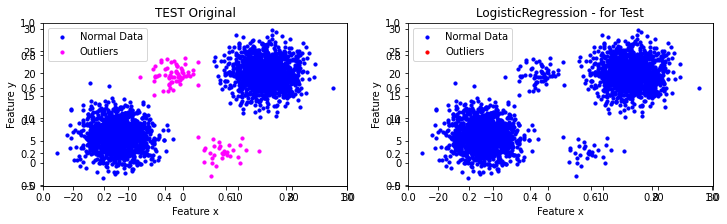

In [133]:
lr_outliers_test = lr.predict(scaled_data_test)
lr_outliers_test = np.array([1 if label == 1 else 0 for label in lr_outliers_test])
anomalies_report(lr_outliers_test)
print(f"f1_score_for_Test:  {f1_score(y_test, lr_outliers_test, average='macro'):6.4f}")

labeled_data_test['is_outlier'] = lr_outliers_test
vizualisation_methods_test(test, labeled_data_test, 'LogisticRegression - for Test')

# Staking

In [134]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_predict

class Stacking(BaseEstimator, ClassifierMixin):  
    """ scikit-learn"""

    def __init__(self, models, ens_model):
        """
        Initialiazation
        models 
        """
        self.models = models
        self.ens_model = ens_model
        self.n = len(models)
        self.valid = None
        
    def fit(self, X, y=None, p=0.25, cv=3, err=0.001, random_state=19):
        """
        Staking training
         p - in what ratio to divide by training / test
             if p = 0 - use all training!
         cv (for p=0) - how many folds to use
         err (for p=0) - value of random addition to metafeatures
         random_state - generator initialization
            
        """
        if (p > 0): # divided into training and test
             # split into training models and metamodel
            train, valid, y_train, y_valid = train_test_split(X, y, test_size=p, random_state=random_state)
            
            # filling the matrix to train the metamodel
            self.valid = np.zeros((valid.shape[0], self.n))
            for t, clf in enumerate(self.models):
                clf.fit(train, y_train)
                self.valid[:, t] = clf.predict(valid)
                
            # metamodel training
            self.ens_model.fit(self.valid, y_valid)
            
        else: #use all training
            
            # for regularization - we take random additions
            self.valid = err*np.random.randn(X.shape[0], self.n)
            
            for t, clf in enumerate(self.models):
                
                self.valid[:, t] += cross_val_predict(clf, X, y, cv=cv, n_jobs=-1, method='predict')
                
                clf.fit(X, y)
            
            # metamodel training
            self.ens_model.fit(self.valid, y)  
            

        return self
    


    def predict(self, X, y=None):
        """
        Staking work
        """
        # filling in the matrix for the meta-classifier
        X_meta = np.zeros((X.shape[0], self.n))
        
        for t, clf in enumerate(self.models):
            X_meta[:, t] = clf.predict(X)
        
        a = self.ens_model.predict(X_meta)
        
        return (a)

#### Rendering feature spaces

In [135]:
#Отрисовка признаковых пространств
from sklearn.metrics import roc_auc_score

def run_and_plot(clf, X, y, label):
    # plt.figure(figsize=(6, 5))
        
    a = clf.predict(X)
    a_uniq = np.unique(a)
    if np.isin(-1, a_uniq[0]):
        a = np.array([1 if label == -1 else 0 for label in a])

    xx, yy = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    
    print (label + ' AUC-ROC  = ' + str( roc_auc_score(y, a) ))
    #print(f"f1_score_for_Train:  {f1_score(y, a, average='macro'):6.4f}")
    print()

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(4, 3))
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 20), cmap=plt.cm.bwr, alpha=0.3) # plt.cm.Blues_r cmap=plt.cm.Blues_r)
    #a_ = plt.contour(xx, yy, Z, levels=[threshold], linewidths=1, colors='black')
    #plt.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='#CCDDFF')
    
    # не всё... :100
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y[:], s=10, alpha=1.0)
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    # plt.axis('tight')
    plt.axis('off')
    plt.title(label)
    return a

#### Basic Algorithms

KNN AUC-ROC  = 0.7446399736857844

isolation_forest AUC-ROC  = 0.7518240535853119

One_SVM AUC-ROC  = 0.5564858561090844

cluster_based_lof AUC-ROC  = 0.9556620417439149



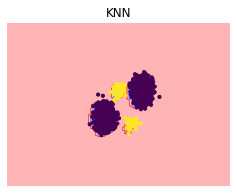

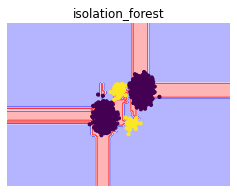

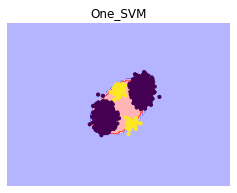

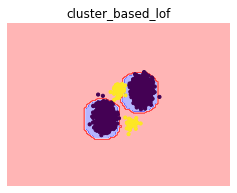

In [136]:
y_test_pred_knn = run_and_plot(knn, scaled_data_test, y_test, 'KNN')

y_test_pred_if = run_and_plot(isolation_forest, scaled_data_test, y_test, 'isolation_forest')

y_test_pred_svm = run_and_plot(one_class_svm, scaled_data_test, y_test, 'One_SVM')

y_test_pred_cblof = run_and_plot(cluster_based_lof, scaled_data_test, y_test, 'cluster_based_lof')



#Classification methods sklearn
#y_test_pred_lr = run_and_plot(lr, scaled_data_test, y_test, 'lr')

#y_test_pred_clf_sgd = run_and_plot(clf_sgd, scaled_data_test, y_test, 'clf_sgd')


#### Checking rendering after using basic algorithms

Data outlier percentage: Original TEST - 3.0 %;                           cblof - 2.97 %
f1_score_for_Test:  0.9630


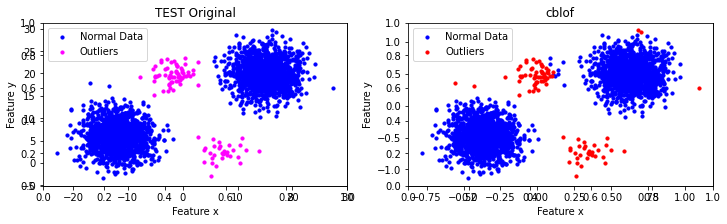

In [137]:
df_test = scaled_data_test.copy()
df_test['is_outlier'] = y_test_pred_cblof
vizualisation_methods_test(test, df_test, 'cblof')
print(f"f1_score_for_Test:  {f1_score(y_test, y_test_pred_cblof, average='macro'):6.4f}")

#### Start Blending and Staking¶

1-stacking AUC-ROC  = 0.9787636056455955

2-stacking AUC-ROC  = 0.9160038275222775



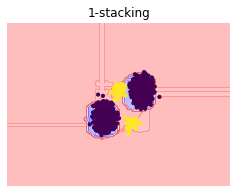

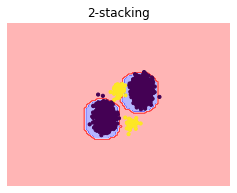

In [140]:
from sklearn.linear_model import Ridge
models = [knn, one_class_svm, isolation_forest, cluster_based_lof] 
ens_model = Ridge()
s1 = Stacking(models, ens_model)
s1.fit(scaled_data_train, y_train)
y_test_pred_1_stacking = run_and_plot(s1, scaled_data_test, y_test, '1-stacking')


s2 = Stacking(models, ens_model)
s2.fit(scaled_data_train, y_train, p=-1)
y_test_pred_2_stacking = run_and_plot(s1, scaled_data_test, y_test, '2-stacking')


Data outlier percentage: Original TEST - 3.0 %;                           stack_1 - 3.33 %
f1_score_for_Test:  0.9677


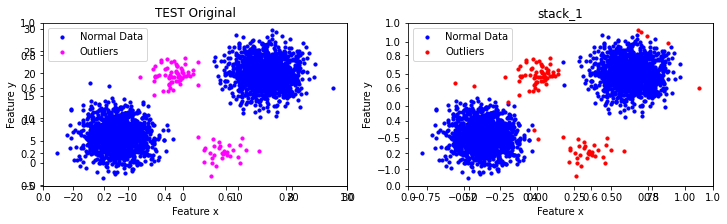

In [141]:
condition = lambda x: (0 if x < 0.5 else 1)
vfunc = np.vectorize(condition)
y_test_pred_stack_1 = vfunc(y_test_pred_1_stacking)

df_test = scaled_data_test.copy()
df_test['is_outlier'] = y_test_pred_stack_1
vizualisation_methods_test(test, df_test, 'stack_1')
print(f"f1_score_for_Test:  {f1_score(y_test, y_test_pred_stack_1, average='macro'):6.4f}")

#### Several Blendings

In [142]:
# models = [knn, isolation_forest, one_class_svm, cluster_based_lof]
ens_model = Ridge(0.0001)
s1 = Stacking(models, ens_model)
a = 0
e_auc = []
f1 = []
for t in range(5):
    s1.fit(scaled_data_train, y_train, p=0.2)
    a += s1.predict(scaled_data_test, y_train)
    
    auc = roc_auc_score(y_test, a)
    print (auc)
    f1_score_= f1_score(y_test, vfunc(a), average='macro') 
    print(f"f1_score_for_Test:  {f1_score(y_test, vfunc(a), average='macro'):6.4f}")
#    e_auc.append(auc)
    f1.append(f1_score_)

0.9286245589378623
f1_score_for_Test:  0.9660
0.9286264278452246
f1_score_for_Test:  0.9660
0.9282993690568745
f1_score_for_Test:  0.9660
0.9283049757789607
f1_score_for_Test:  0.9660
0.9280377220261945
f1_score_for_Test:  0.9660


In [269]:
e4 = f1

#### Varying the Number of Folds

In [143]:
# models = [knn, isolation_forest, one_class_svm, cluster_based_lof]
ens_model = Ridge(0.001)

s1 = Stacking(models, ens_model)
a = 0
e = []
f1 = []
for t in range(2, 6):
    s1.fit(scaled_data_train, y_train, p=-1, cv=t, err=0.00)
    a = s1.predict(scaled_data_test, y_train)
    auc = roc_auc_score(y_test, a)
    print (auc)
#    e.append(auc)
    f1_score_= f1_score(y_test, vfunc(a), average='macro') 
    print(f"f1_score_for_Test:  {f1_score(y_test, vfunc(a), average='macro'):6.4f}")
    f1.append(f1_score_)

0.9138321571676333
f1_score_for_Test:  0.9630
0.9142806949345135
f1_score_for_Test:  0.9630
0.9160860594462054
f1_score_for_Test:  0.9630
0.9465623317983374
f1_score_for_Test:  0.9630


In [145]:
e1 = f1

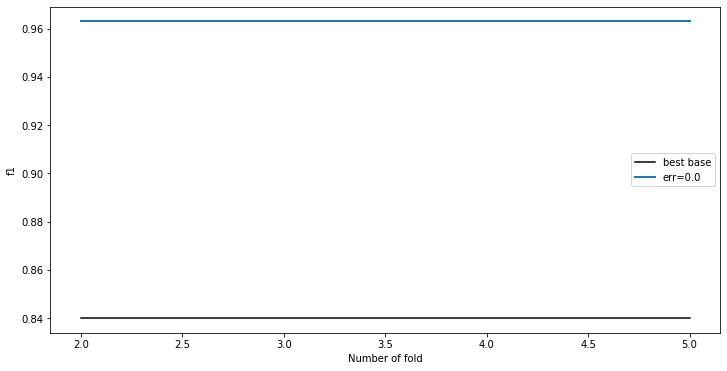

In [146]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(2,6), 0.84 + 0*np.arange(2,6), c='black', label='best base')
plt.plot(np.arange(2,6), e1, label='err=0.0', lw=2)
#plt.plot(np.arange(2,11), e3, label='err=0.01', lw=2)
#plt.plot(np.arange(2,6), e2, label='err=0.03', lw=2)
# plt.plot(np.arange(2,11), e4, label='p=0.4', lw=2)
plt.xlabel(u'Number of fold')
#plt.ylabel('AUC ROC')
plt.ylabel('f1')
plt.legend()

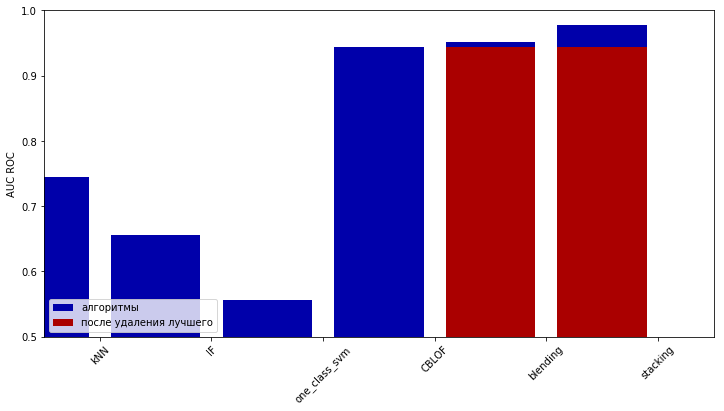

In [319]:
#AUC-ROC
tmp = [('kNN', 0.744), 
       ('IF', 0.655),
       ('one_class_svm', 0.556),
       ('CBLOF', 0.944),
       ('blending', 0.9520),
       ('stacking', 0.978)]



xticks = [x[0] for x in tmp]
aucs = [x[1] for x in tmp]

plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(aucs)), aucs, color='#0000AA', label=u'алгоритмы')
plt.xticks(np.arange(len(aucs))+0.5, xticks, rotation=45)

plt.bar([4, 5], [0.944, 0.944], color='#AA0000', label=u'после удаления лучшего')


plt.xlim([0, 6])
plt.ylim([0.5, 1])
plt.ylabel('AUC ROC')
plt.legend(loc=3)

# Building an ensemble

In [149]:
from mlens.ensemble import SuperLearner

[MLENS] backend: threading


In [150]:
# --- Build ---
# Passing a scoring function will create cv scores during fitting
# the scorer should be a simple function accepting to vectors and returning a scalar
ensemble = SuperLearner(scorer=accuracy_score, random_state=42, verbose=2)

# Build the first layer
ensemble.add([knn, one_class_svm, isolation_forest, cluster_based_lof])

# Attach the final meta estimator
ensemble.add_meta(Ridge(0.01))

# --- Use ---

# Fit ensemble
ensemble.fit(scaled_data_train, y_train)

# Predict
preds = ensemble.predict(scaled_data_test)


Fitting 2 layers
Processing layer-1             done | 00:00:03
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:04

Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:01



Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:01
ensemble AUC-ROC  = 0.9158094611566294


Predicting 2 layers
Processing layer-1             done | 00:00:02
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:03


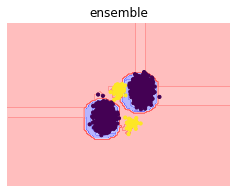

In [151]:
y_test_pred_ensemble = run_and_plot(ensemble, scaled_data_test, y_test, 'ensemble')

Data outlier percentage: Original TEST - 3.0 %;                           Ensemble - 2.97 %
f1_score_for_Test:  0.9630


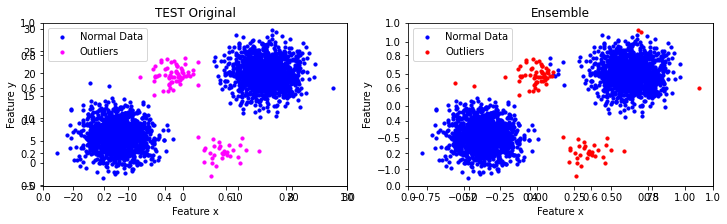

In [153]:
condition = lambda x: (0 if x < 0.1 else 1)
vfunc = np.vectorize(condition)
preds_2 = vfunc(preds)

df_test = scaled_data_test.copy()
df_test['is_outlier'] = preds_2
vizualisation_methods_test(test, df_test, 'Ensemble')
print(f"f1_score_for_Test:  {f1_score(y_test, preds_2, average='macro'):6.4f}")